In [2]:
import math
from graphviz import Digraph

In [75]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
        
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other) -> 'Value':
        other = other if isinstance(other, Value) else Value(other)
        
        out = Value(self.data + other.data,
                    _children=(self, other),
                    _op='+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other) -> 'Value':
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data,
                    _children=(self, other),
                    _op='*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __rmul__(self, other) -> 'Value':
        return self * other
    
    def __neg__(self):
        return self *-1
        
    def __sub__(self, other) -> 'Value':
        return self + (-other)
    
    def __rsub__(self, other):
        return -1*(self +(-other))
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += (other * self.data ** (other-1)) * out.grad
            
        out._backward = _backward
        
        return out
        
    def __truediv__(self, other) -> 'Value':
        return self*other**-1
    
    def exp(self) -> 'Value':
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
            
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh') 
        
        def _backward():
            self.grad = (1 - t**2) * out.grad
            
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        
        for node in reversed(topo):
            node._backward()
        

In [4]:
a = Value(4.0)
b = Value(2.0)

a - b

Value(data=2.0)

In [5]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [6]:
a = Value(3, label='a')
b = Value(4, label='b')
c = Value(-2, label='c')

e = a + b; e.label='e'
f = e - c; f.label = 'f'
d = 2 * a * f - e; d.label='d'
d

Value(data=47)

In [7]:
a = Value(2., label='a')
b = Value(-3., label='b')
c = Value(10., label='c')

e = a*b; e.label = 'e'
d = e+c; d.label='d'
f = Value(-2., label='f')
L = d * f; L.label='L'

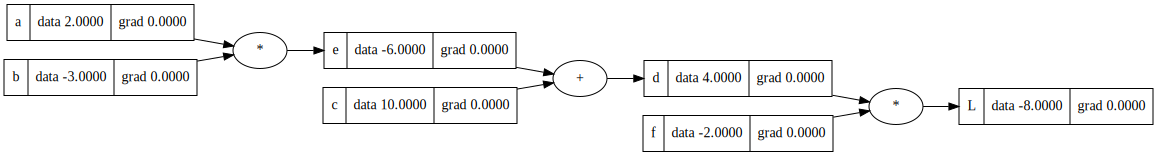

In [8]:
draw_dot(L)

In [9]:
L.grad = 1.
f.grad = 4.0
d.grad = -2.0

c.grad = -2.0 * 1
e.grad = -2.0 * 1

a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

In [10]:
dL / df = d = 4.0
dL/ dd = f = -2.0

    L = f * d
    symmetrical: respect to d

    (f(x+h) - f(x)) / h
    ((f*(d +h)) - f*d)h
    (fd + fh - fd) /h 
    fh/h = f -> 
    dL/dd = f ->
    dL/df = d

dL/dc = (dL/dd)*(dd/dc) = -2.0 * 1 = -2.
dL/de = (dL/dd)*(dd/de) = -2.0 * 1 = -2.0

    d = e + c
    dd/de symmetrical to dd/dc = 1
    dd/de:
    (f(x+h) - f(x))/h
    ((c + e+h) - (c+h))/h
    (h)/h = 1
    
dL/da = dL/de * de/da = dL/dd * dd/de * de/da = -2.0 * 1.0 * -3.0 = 6.0
dL/db = dL/de * de/db = dL/dd * dd/de * de/db = -2.0 * 1.0 * 2.0 = -4.0

    de/da = -3.0
    de/db = 2.0
    e = a * b
    de/da = b -> de/db = a
    (f(x+h) - f(x))/h
    ((a+h) * b - a*b)/h
    (a*b + b*h - a*b)/h
    (b*h)/h = b

SyntaxError: cannot assign to operator (Temp/ipykernel_35408/3468372951.py, line 1)

In [11]:

# o = tanh(n)
# do/dn = 1 - tanh(n)**2 = 1- o**2
# + sighn works as a gradient distributor

In [12]:
o.grad = 1.0
n.grad = 0.5 #1 - o.data**2  according to derivative of tanh function

x1w1x2w2.grad = 0.5
b.grad = 0.5

x1w1.grad = 0.5
x2w2.grad = 0.5

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

NameError: name 'o' is not defined

In [13]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'
o.backward()
n, o

(Value(data=0.8813735870195432), Value(data=0.7071067811865476))

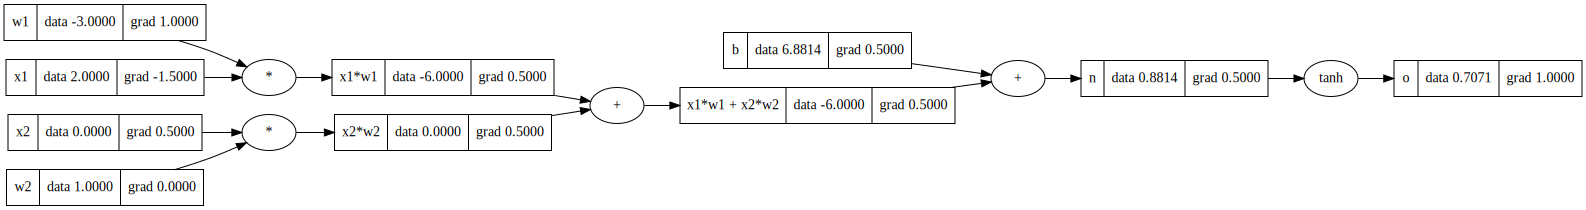

In [14]:
draw_dot(o)

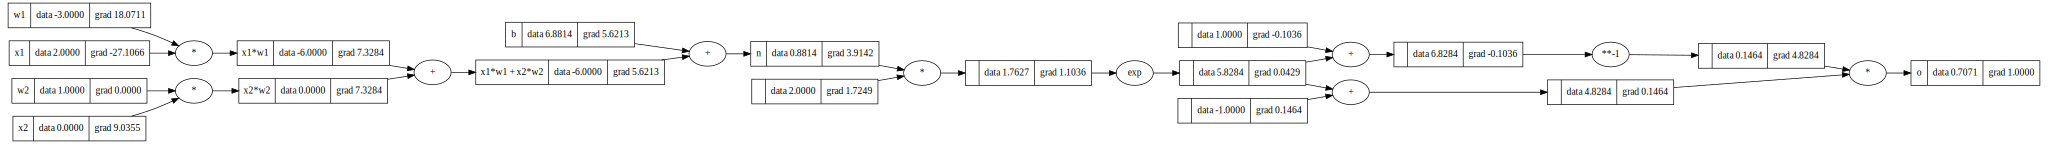

In [15]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'

e = (2*n).exp()
o = (e-1)/(e+1)
o.label='o'
o.backward()
draw_dot(o)

In [16]:
import random

In [70]:
class Neuron:
    
    def __init__(self, nin, label=''):
        self.w = [Value(random.uniform(-1,1), label=label+'_n'+str(i)) for i in range(nin)]
        self.b = Value(random.uniform(-1,1), label=label+'_b')
        
    def __call__(self, x):
      act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
      out = act.tanh()
      return out
            
            
class Layer:
    
    def __init__(self, nin, nout, label='') -> None:
        self.neurons = [Neuron(nin, label=f'l{i}') for i in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
class MLP:
    
    def __init__(self, nin, nouts) -> None:
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [76]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4 ,1 ])
n(x)

Value(data=-0.6327627703275799)

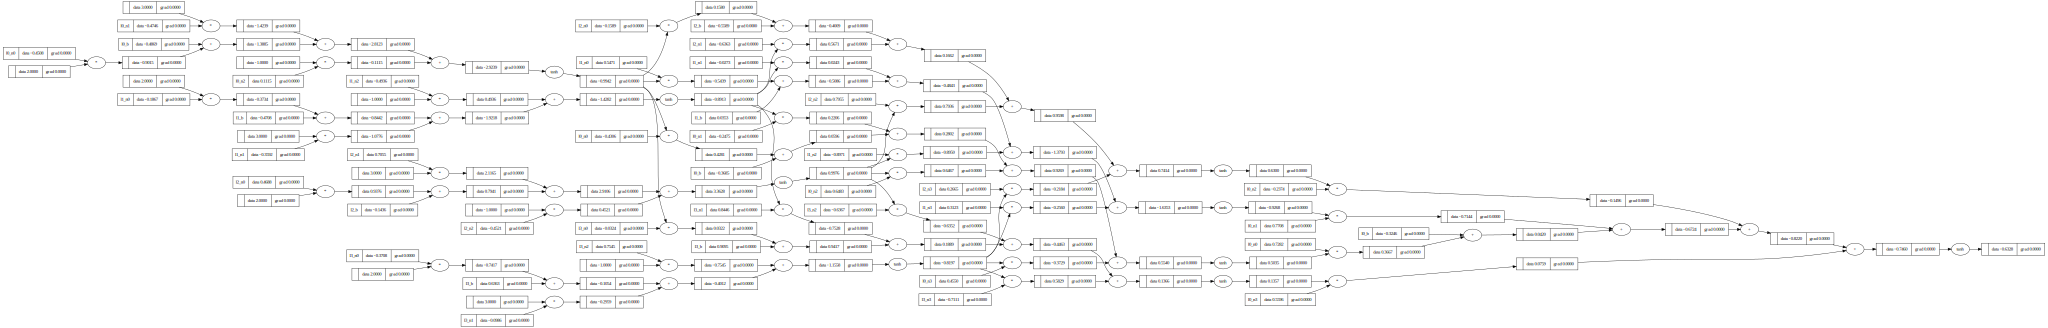

In [77]:
draw_dot(n(x))

In [78]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]

ypred = [n(x) for x in xs]
ypred

[Value(data=-0.6327627703275799),
 Value(data=-0.47950125110813047),
 Value(data=-0.5278257290271147),
 Value(data=-0.5407938482139614)]

In [79]:
loss = sum((yout-ygt)**2 for yout, ygt in zip(ys, ypred))
loss

Value(data=5.533827436628559)

In [80]:
loss.backward()

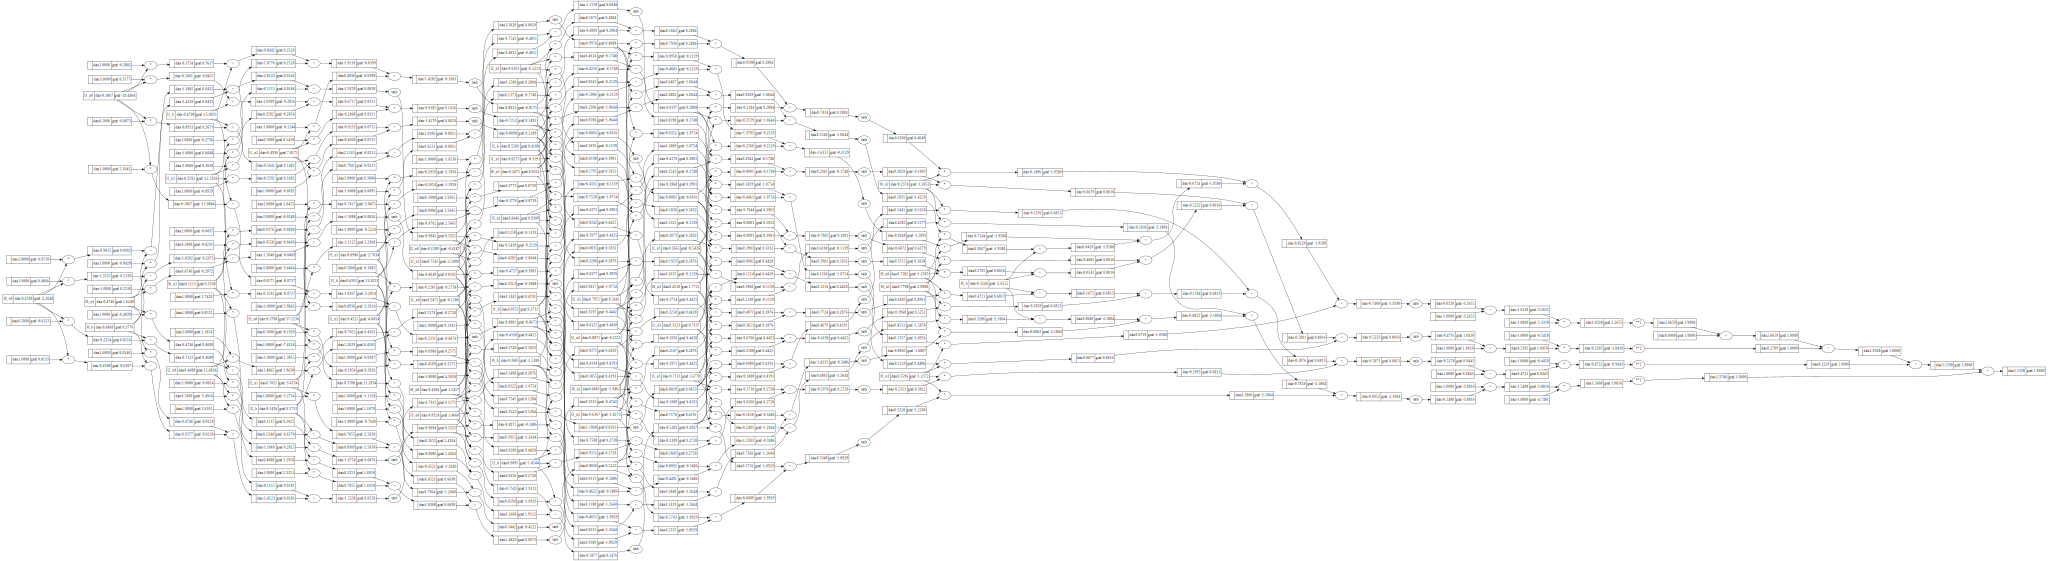

In [81]:
draw_dot(loss)